In [76]:
from numpy import zeros
from numpy import asarray
import os
import numpy as np
import cv2
from keras.models import Model
from keras.layers import Input
from matplotlib import pyplot
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.utils import plot_model
from PIL import Image
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization,MaxPool2D,SeparableConv2D,DepthwiseConv2D,concatenate,LeakyReLU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.xception import Xception
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

import os

#connect with drive
from google.colab import drive
drive.mount('/content/drive')


!unzip '/content/drive/MyDrive/datasets/plant_disease.zip' -d '/content/'


# classes
classes_names=["Tomato___Bacterial_spot","Tomato___Early_blight","Tomato___Late_blight",
               "Tomato___Leaf_Mold","Tomato___Septoria_leaf_spot",
               "Tomato___Spider_mites Two-spotted_spider_mite",
               "Tomato___Target_Spot","Tomato___Tomato_Yellow_Leaf_Curl_Virus",
               "Tomato___Tomato_mosaic_virus","Tomato___healthy"]



# taking images from directory
labels = list()
img_data = list()
l = 0
for j in range(0,10):
  path=('/content/Plant_leave_diseases_dataset_without_augmentation/'+classes_names[j])

  for root,dirs,files in os.walk(path):
      for file in files:
          if file.endswith('.jpg') or file.endswith('.JPG'):
              image = cv2.imread(os.path.join(root,file))
              image = cv2.resize(image,(224,224))
              img_data.append(image)
              labels.append(l)
      l = l+1

# spliting dataset
x1_train,x_test,y1_train,y_test = train_test_split(img_data,labels,test_size=0.2)
x_train,vx_test,y_train,vy_test = train_test_split(x1_train,y1_train,test_size=0.25)

#see length of test & traing
print(len(y_train))
print(len(y_test))
print(len(vy_test))

Streaming output truncated to the last 5000 lines.
  inflating: /content/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: /content/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: /content/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: /content/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: /content/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1326).JPG  
  inflating: /content/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1327).JPG  
  inflating: /content/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1328).JPG  
  inflating: /content/Plant_leave_disea

In [2]:
!unzip '/content/drive/MyDrive/trained_model/leaf_model/checkpoint-455-val_acc-0.9937.weights.h5.zip' -d '/'

Archive:  /content/drive/MyDrive/trained_model/leaf_model/checkpoint-455-val_acc-0.9937.weights.h5.zip
  inflating: /content/trained_models/checkpoint-455-val_acc-0.9937.weights.h5  


In [77]:
model1 = Sequential([

    tf.keras.layers.SeparableConv2D(32,(3,3),input_shape=(224,224,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.SeparableConv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.SeparableConv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.SeparableConv2D(32,(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.SeparableConv2D(32,(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')])

model1.compile(loss='categorical_crossentropy',
              optimizer= keras.optimizers.AdamW(learning_rate=0.001), metrics=['accuracy'])

In [78]:
model1.load_weights('/content/trained_models/checkpoint-455-val_acc-0.9937.weights.h5')

In [85]:
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomTranslation(height_factor=(0.1),width_factor=(0.1)),
])

re_vx_test=list()
for ii in range(len(vx_test)):
  re_vx_test.append(resize_and_rescale(vx_test[ii]))

au_vx_test = list()
for uu in range(len(re_vx_test)):
  img = tf.expand_dims(re_vx_test[uu], axis=0)
  au_vx_test.append(data_augmentation(img[0]))

In [86]:
au_vx_test = asarray(au_vx_test)
vy_test = to_categorical(vy_test)

In [87]:
test_loss,test_acc=model1.evaluate(au_vx_test,vy_test)# ori
test_acc

114/114 [==============================] - 65s 564ms/step - loss: 0.0200 - accuracy: 0.9942


0.9942180514335632

In [88]:
pred = model1.predict(au_vx_test)

114/114 [==============================] - 67s 580ms/step


In [89]:
ac_list=[]
for i, vv in enumerate(vy_test):
    ac_list.append(np.argmax(vv))


index=[]
for i, p in enumerate(pred):
    index.append(np.argmax(p))


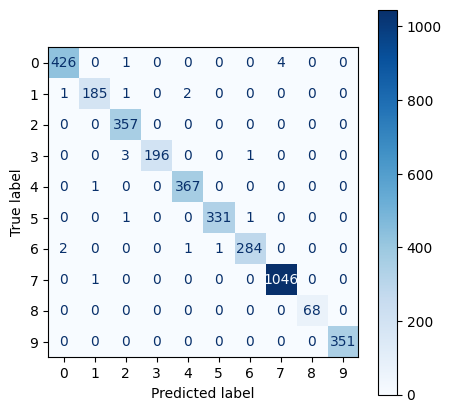

In [90]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(5, 5))

labels = [0,1,2,3,4,5,6,7,8,9]

cm = confusion_matrix(ac_list,index)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.show()

In [91]:
ac_list = np.asarray(ac_list)
index = np.asarray(index)

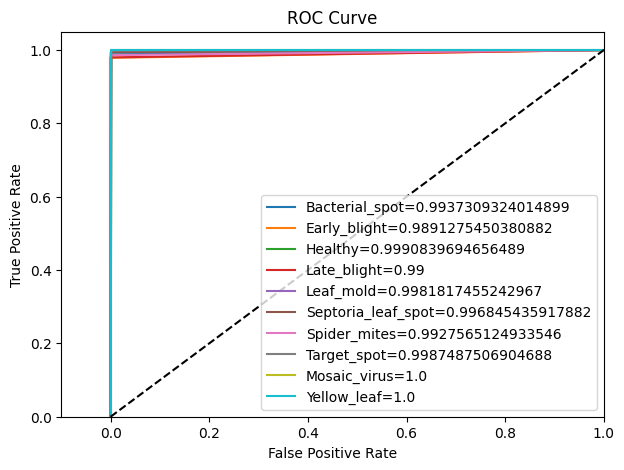

In [92]:


from sklearn.metrics import auc, roc_curve

labels = ['Bacterial_spot','Early_blight','Healthy','Late_blight','Leaf_mold',
'Septoria_leaf_spot','Spider_mites','Target_spot','Mosaic_virus','Yellow_leaf']

ns_fpr = dict()
ns_tpr = dict()
roc_auc = dict()
n_classes =10
for i in range(n_classes):
  ns_fpr[i], ns_tpr[i], _ = roc_curve(ac_list[:]==i, index[:]==i)
  roc_auc[i] = auc(ns_fpr[i],ns_tpr[i])
# plot the roc curve for the model
fig, ax = plt.subplots(figsize=(7, 5))

for i in range(n_classes):
  plt.plot(ns_fpr[i], ns_tpr[i], label=str(labels[i])+"="+str(roc_auc[i]))
plt.plot([0, 2], [0, 2], 'k--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig('ROC_input100.png')
plt.close()

In [67]:
import tensorflow as tf
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder




def get_flops(model):
  forward_pass = tf.function(model.call, input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])
  graph_info = profile(forward_pass.get_concrete_function().graph, options=ProfileOptionBuilder.float_operation())
  flops = graph_info.total_float_ops
  return flops

flops = get_flops(model1)
macs = flops / 2
print(f"MACs: {macs / 1e+9:,} G")
print(f"FLOPs: {flops / 1e+9:,} G")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


MACs: 0.05083889 G
FLOPs: 0.10167778 G
